In [76]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.inspection import permutation_importance

In [77]:
booking_data = pd.read_csv("./proccessedBookings.csv")
expedia_data = pd.read_csv("./bookingsSecond.csv")

In [78]:
def add_check_in_col(df):
    df['snapshot_date'] = pd.to_datetime(df['snapshot_date'], format='%Y-%m-%d')  # Correct format
    df['checkin_date'] = df['snapshot_date'] + pd.to_timedelta(df['time_to_travel'], unit='D')  # Add days
    df['checkin_day'] = df['checkin_date'].dt.day  # Extract day of the month

In [79]:
add_check_in_col(booking_data)
add_check_in_col(expedia_data)

In [80]:
booking_data = booking_data.drop_duplicates(subset=['name', 'checkin_date', 'length_of_stay'])
expedia_data = expedia_data.drop_duplicates(subset=['name', 'checkin_date', 'length_of_stay'])

In [81]:
merged_data = pd.merge(booking_data, expedia_data, on=['name', 'checkin_date','length_of_stay'], suffixes=('_booking', '_expedia'), how='inner')

In [82]:
print(booking_data.__len__())
print(expedia_data.__len__())
print(merged_data.__len__())
display(merged_data.head())


18561
22409
18560


,Unnamed: 0.1,Unnamed: 0_booking,name,original_price_booking,discounted_price_booking,discount_booking,review_score_booking,review_title_booking,number_of_reviews_booking,star_rating_booking,...,kms_from_centre_expedia,location_score_expedia,bed_type_expedia,room_type_expedia,breakfast_included_expedia,free_cancellation,prepayment_needed,time_to_travel_expedia,snapshot_date_expedia,checkin_day_expedia
0,0,0.0,Iroquois New York Times Square,292.0,218.0,True,8.5,4.0,2625.0,5.0,...,NaN,9.7,1 large double bed,Superior 1 Queen Bed,True,False,True,1,2025-02-02,3
1,1,1.0,Four Points by Sheraton New York Downtown,130.0,111.0,True,7.8,3.0,1987.0,3.0,...,NaN,NaN,1 extra-large double bed,"Guest Room, 1 King",False,True,False,1,2025-02-02,3
2,2,2.0,"The Mayfair Hotel Times Square, Ascend Hotel C...",141.0,141.0,False,8.6,5.0,1895.0,3.0,...,NaN,9.6,1 double bed,Deluxe Double Room - Non Smoking,False,False,True,1,2025-02-02,3
3,3,3.0,The Washington by LuxUrban,160.0,160.0,False,7.7,3.0,9442.0,4.0,...,NaN,9.4,1 single bed,Room Assigned on Arrival,False,False,True,1,2025-02-02,3
4,4,4.0,Hampton Inn by Hilton New York Times Square,152.0,152.0,False,7.8,3.0,2432.0,3.0,...,NaN,9.5,1 extra-large double bed,King Bed with City View,True,False,True,1,2025-02-02,3


In [83]:
merged_data['price_difference'] = merged_data['discounted_price_booking'] - merged_data['discounted_price_expedia']

In [85]:
merged_data['checkin_date'] = pd.to_datetime(merged_data['checkin_date'])
merged_data['checkin_date'] = (merged_data['checkin_date'] - merged_data['checkin_date'].min()).dt.days


In [86]:
X = merged_data[['checkin_date', 'length_of_stay']]  # Replace with actual features
y = merged_data['price_difference']

In [87]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [88]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [89]:
models = {
    'Linear Regression': LinearRegression(),
    'Decision Tree': DecisionTreeRegressor(),
    'Random Forest': RandomForestRegressor(n_estimators=100)
}

In [90]:
results = {}

for name, model in models.items():
    model.fit(X_train_scaled, y_train)
    y_pred = model.predict(X_test_scaled)
    print(f'fit and pred: {name}')
    # Calculate performance metrics
    results[name] = {
        'R2': r2_score(y_test, y_pred),
        'MAE': mean_absolute_error(y_test, y_pred),
        'MSE': mean_squared_error(y_test, y_pred),
        'RMSE': np.sqrt(mean_squared_error(y_test, y_pred))
    }
    print(f'logged: {name}')


fit and pred: Linear Regression
logged: Linear Regression
fit and pred: Decision Tree
logged: Decision Tree
fit and pred: Random Forest
logged: Random Forest


In [91]:
results_df = pd.DataFrame(results).T
print(results_df)

                         R2       MAE        MSE      RMSE
Linear Regression  0.001148  0.177370  14.357807  3.789170
Decision Tree     -0.000828  0.136353  14.386208  3.792915
Random Forest     -0.000333  0.139632  14.379095  3.791978


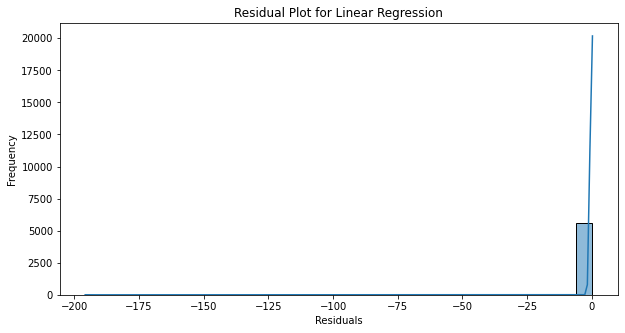

In [92]:
best_model_name = results_df['R2'].idxmax()
best_model = models[best_model_name]
y_pred_best = best_model.predict(X_test_scaled)
residuals = y_test - y_pred_best

plt.figure(figsize=(10, 5))
sns.histplot(residuals, bins=30, kde=True)
plt.title(f'Residual Plot for {best_model_name}')
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.show()


C:\Users\Ilai\AppData\Local\Temp/ipykernel_29700/572544589.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=importance_df, palette="Blues_d")


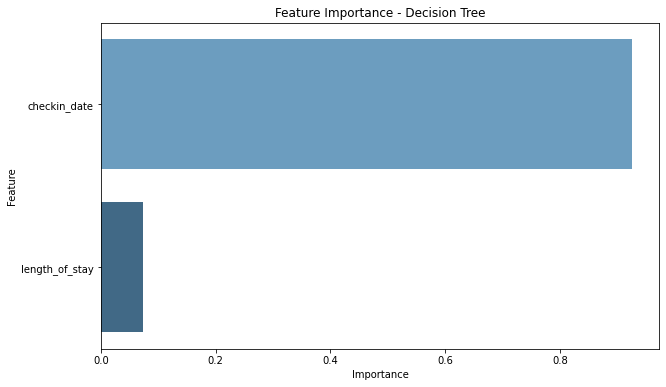

C:\Users\Ilai\AppData\Local\Temp/ipykernel_29700/572544589.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=importance_df, palette="Blues_d")


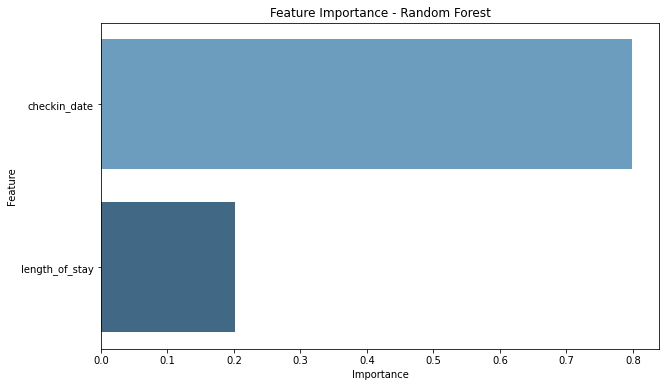

In [93]:
for model_name in ['Decision Tree', 'Random Forest']:
    model = models[model_name]
    feature_importance = model.feature_importances_
    
    importance_df = pd.DataFrame({
        'Feature': X.columns,
        'Importance': feature_importance
    }).sort_values(by='Importance', ascending=False)

    plt.figure(figsize=(10, 6))
    sns.barplot(x='Importance', y='Feature', data=importance_df, palette="Blues_d")
    plt.title(f'Feature Importance - {model_name}')
    plt.show()

C:\Users\Ilai\AppData\Local\Temp/ipykernel_29700/385583814.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=perm_importance_df, palette="Greens_d")


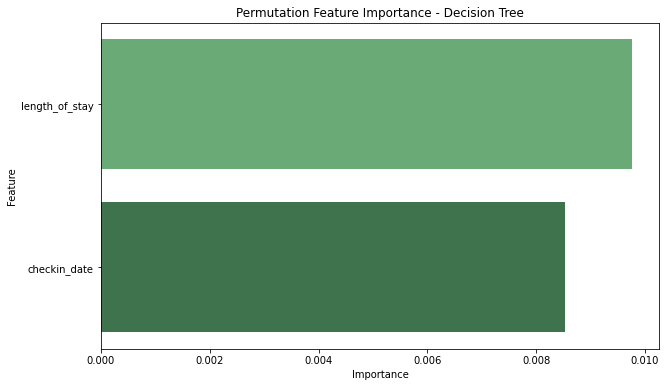

C:\Users\Ilai\AppData\Local\Temp/ipykernel_29700/385583814.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=perm_importance_df, palette="Greens_d")


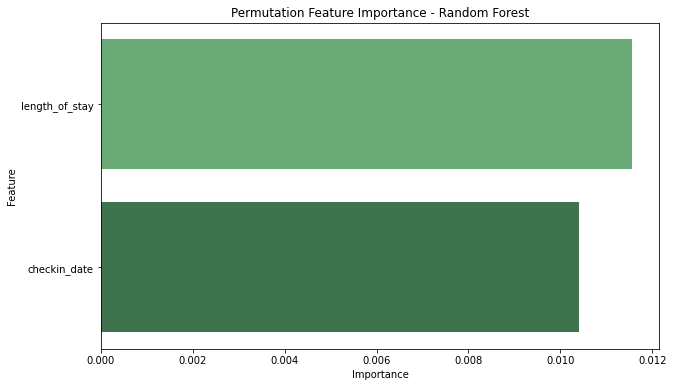

In [94]:
for model_name in ['Decision Tree', 'Random Forest']:
    model = models[model_name]
    perm_importance = permutation_importance(model, X_test_scaled, y_test, n_repeats=10, random_state=42)
    
    perm_importance_df = pd.DataFrame({
        'Feature': X.columns,
        'Importance': perm_importance.importances_mean
    }).sort_values(by='Importance', ascending=False)

    plt.figure(figsize=(10, 6))
    sns.barplot(x='Importance', y='Feature', data=perm_importance_df, palette="Greens_d")
    plt.title(f'Permutation Feature Importance - {model_name}')
    plt.show()
